In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np

import os
import datetime as dt
from functools import wraps, reduce

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR
from utils.utils import *
from utils.load import save_file, load_data
from utils.cast_data import apply_datetime_format, apply_textmonth_to_nummonth, apply_date_to_week

In [4]:
# load raw format
fears = load_data(file_name="fears.csv", file_path=RAW_DATA_DIR)

cbeo_vix = load_data(file_name="cbeo_vix.csv", file_path=RAW_DATA_DIR).rename(columns={"Date": "date"})
cbeo_vix.drop_duplicates("date", keep="last", inplace=True)
cbeo_vix.reset_index(drop=True, inplace=True)
cbeo_vix.drop(['vxdh', 'vxd', 'vxdl', 'vxdo', 'vxn', 'vxnh', 'vxnl', 'vxno', 'vxo', 'vxoh', 'vxol', 'vxoo'], axis=1, inplace=True)

naaim_risk = load_data(file_name="naaim_risk.xlsx", file_path=RAW_DATA_DIR).rename(columns={"Date": "date",
                                                                                            "NAAIM Number": "naaim_ind",
                                                                                            "Most Bearish Response": "naaim_max",
                                                                                            "Quart 1 (25% at/below)": "naaim_q1",
                                                                                            "Standard Deviation": "naaim_std"}).iloc[:-4].sort_values("date").reset_index(drop=True)
naaim_risk = naaim_risk.loc[naaim_risk.date.drop_duplicates().index]

ff_factors5 = load_data(file_name="ff_factors5.csv", file_path=RAW_DATA_DIR, skiprows=3).add_prefix("ff_").rename(columns={"ff_Unnamed: 0" : "date",
                                                                                                                           "ff_Mkt-RF": "ff_M_RF"}).iloc[:-1]
ff_factors3 = load_data(file_name="ff_factors3.csv", file_path=RAW_DATA_DIR, skiprows=3).add_prefix("ff_").add_suffix("_3").rename(columns={"ff_Unnamed: 0_3" : "date",
                                                                                                                                            "ff_Mkt-RF_3": "ff_M_RF_3"}).iloc[:-1]

us_termspread = load_data(file_name="us_termspread.csv", file_path=RAW_DATA_DIR).rename(columns={"DATE": "date", "TEDRATE": "termspread"})
us_termspread["termspread"] = us_termspread["termspread"].replace({"." : np.nan})

aaii_bull = load_data(file_name="aaii_bull.xlsx", file_path=RAW_DATA_DIR, sheet_name="raw_data").iloc[:, :10].add_prefix("aaii_").rename(columns={"aaii_Reported Date": "date"})
sp500 = load_data(file_name="sp500_yf.xlsx", file_path=RAW_DATA_DIR, sheet_name="sp500").add_prefix("sp_").rename(columns=
                                                                                                                  {
                                                                                                                      "sp_Date": "date",
                                                                                                                      "sp_Volume": "sp_volume",
                                                                                                                      "sp_Close*": "sp_close",
                                                                                                                      "sp_Adj Close**": "sp_adj_close"
                                                                                                                  }
                                                                                                                 ).sort_values("date", ascending=True).reset_index(drop=True)

pc1 = load_data(file_name="cboe_putcall_total_2003-2012.csv", file_path=RAW_DATA_DIR, skiprows=2).rename(columns={"Trade_date": "date", "P/C Ratio": "pc_ratio"})
pc2 = load_data(file_name="cboe_putcall_total_2006-2019.csv", file_path=RAW_DATA_DIR, skiprows=2).rename(columns={"DATE": "date",
                                                                                                        "CALLS": "Call",
                                                                                                        "PUTS": "Put",
                                                                                                        "TOTAL": "Total",
                                                                                                        "P/C Ratio": "pc_ratio"})
goog_sent = load_data(file_name="gog_sent.csv", file_path=RAW_DATA_DIR)
goog_sent = goog_sent[goog_sent.country=="United States"].drop(["Unnamed: 0", "country"], axis=1).rename(columns={"sentiment_combined": "goog_sent",
                                                                                                                  "week": "date"}).reset_index(drop=True)
;

Unknown columns found, columns were not casted
['Date', 'vxoo', 'vxoh', 'vxol', 'vxo', 'vxno', 'vxnh', 'vxnl', 'vxn', 'vxdo', 'vxdh', 'vxdl']
Exceptions were found
[KeyError('Date'), KeyError('vxoo'), KeyError('vxoh'), KeyError('vxol'), KeyError('vxo'), KeyError('vxno'), KeyError('vxnh'), KeyError('vxnl'), KeyError('vxn'), KeyError('vxdo'), KeyError('vxdh'), KeyError('vxdl')]
Unknown columns found, columns were not casted
['Date', 'Standard Deviation', 'NAAIM Number']
Exceptions were found
[KeyError('Date'), KeyError('Standard Deviation'), KeyError('NAAIM Number')]
Unknown columns found, columns were not casted
['Unnamed: 0', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
Exceptions were found
[KeyError('Unnamed: 0'), KeyError('Mkt-RF'), KeyError('SMB'), KeyError('HML'), KeyError('RMW'), KeyError('CMA'), KeyError('RF')]
Unknown columns found, columns were not casted
['Unnamed: 0', 'Mkt-RF', 'SMB', 'HML', 'RF']
Exceptions were found
[KeyError('Unnamed: 0'), KeyError('Mkt-RF'), KeyError('SM

''

In [5]:
# create cast_dict
_ = list(fears.columns)
_.extend(list(cbeo_vix.columns))
_.extend(list(naaim_risk.columns))
_.extend(list(ff_factors3.columns))
_.extend(list(ff_factors5.columns))
_.extend(list(us_termspread.columns))
_.extend(list(pc1.columns))
_.extend(list(aaii_bull.columns))
_.extend(list(sp500.columns))
_.extend(list(goog_sent.columns))

_ = list(set(_))
_.sort()
# {item: float for item in _}

In [6]:
# save files in feather format
save_file(fears, file_name="fears.csv", file_path=WORK_DATA_DIR, index=False)
save_file(cbeo_vix, file_name="cbeo_vix.csv", file_path=WORK_DATA_DIR, index=False)
save_file(naaim_risk, file_name="naaim_risk.csv", file_path=WORK_DATA_DIR, index=False)
save_file(ff_factors5, file_name="ff_factors5.csv", file_path=WORK_DATA_DIR, index=False)
save_file(ff_factors3, file_name="ff_factors3.csv", file_path=WORK_DATA_DIR, index=False)
save_file(us_termspread, file_name="us_termspread.csv", file_path=WORK_DATA_DIR, index=False)
save_file(pc1, file_name="put_call1.csv", file_path=WORK_DATA_DIR, index=False)
save_file(pc2, file_name="put_call2.csv", file_path=WORK_DATA_DIR, index=False)
save_file(aaii_bull, file_name="aaii_bull.csv", file_path=WORK_DATA_DIR, index=False)
save_file(sp500, file_name="sp500.csv", file_path=WORK_DATA_DIR, index=False)
save_file(goog_sent, file_name="goog_sent.csv", file_path=WORK_DATA_DIR, index=False)

Load data files

In [7]:
fears = load_data(file_name="fears.csv", file_path=WORK_DATA_DIR)
cbeo_vix = load_data(file_name="cbeo_vix.csv", file_path=WORK_DATA_DIR)
naaim_risk = load_data(file_name="naaim_risk.csv", file_path=WORK_DATA_DIR)
ff_factors5 = load_data(file_name="ff_factors5.csv", file_path=WORK_DATA_DIR)
ff_factors3 = load_data(file_name="ff_factors3.csv", file_path=WORK_DATA_DIR)
us_termspread = load_data(file_name="us_termspread.csv", file_path=WORK_DATA_DIR)
put_call1 = load_data(file_name="put_call1.csv", file_path=WORK_DATA_DIR)
put_call2 = load_data(file_name="put_call2.csv", file_path=WORK_DATA_DIR)
aaii_bull = load_data(file_name="aaii_bull.csv", file_path=WORK_DATA_DIR)
sp500 = load_data(file_name="sp500.csv", file_path=WORK_DATA_DIR)
goog_sent = load_data(file_name="goog_sent.csv", file_path=WORK_DATA_DIR, europe_time_slash=True)

put_call = pd.concat([put_call1,
                      put_call2.set_index("date").loc[put_call1.iloc[-1].date:].iloc[1:].reset_index()],
                     axis=0).reset_index(drop=True)

In [8]:
data_dict = {}
data_dict.update(
    {
        "data": {
            "df_cols" : 
            {
                "fears": list(fears.drop("date", axis=1).columns),
                "cbeo_vix": list(cbeo_vix.drop("date", axis=1).columns),
                "naaim_risk": list(naaim_risk.drop("date", axis=1).columns),
                "ff_factors5": list(ff_factors5.drop("date", axis=1).columns),
                "termspread": list(us_termspread.drop("date", axis=1).columns),
                "put_call": list(put_call.drop("date", axis=1).columns),
                "aaii_bull": list(aaii_bull.drop("date", axis=1).columns),
                "sp500": list(sp500.drop("date", axis=1).columns),
                "goog_sent": list(goog_sent.drop("date", axis=1).columns)
            }
        },
        "data_transformation": {},
        "data_stests": {},
        "model_features": {},
        "model_metrics": {},
    }
)

dict_df = dict(zip( ["fears", "cbeo_vix", "naaim_risk", "ff_factors3", "ff_factors5", "us_termspread", "put_call", "aaii_bull", "sp500", "goog_sent"],
                   [fears, cbeo_vix, naaim_risk, ff_factors3, ff_factors5, us_termspread, put_call, aaii_bull, sp500, goog_sent]))

Week overview

In [9]:
get_df_time_overview_report(dict_df)

,min,max,days,weeks,days_perc,week_or_day
fears,2004-07-01,2011-12-30,2738,391,0.690650,1.448677
cbeo_vix,1990-01-02,2021-09-30,11594,1656,0.690271,1.448888
naaim_risk,2006-08-02,2022-02-16,5677,811,0.142857,7.008642
ff_factors3,1926-07-01,2021-12-31,34882,4983,0.720945,1.387124
ff_factors5,1963-07-01,2021-12-30,21367,3052,0.689240,1.450971
us_termspread,1986-01-02,2022-01-21,13168,1881,0.714383,1.399957
put_call,2003-10-17,2019-10-04,5831,833,0.689076,1.451581
aaii_bull,1987-07-23,2022-01-05,12585,1798,0.142789,7.007238
sp500,1990-01-02,2021-12-30,11685,1669,0.690030,1.449392
goog_sent,2004-07-05,2014-12-22,3822,546,0.143119,7.000000


In [10]:
aaii_bull["week"] = aaii_bull.date.apply(lambda x: apply_date_to_week(x))
naaim_risk["week"] = naaim_risk.date.apply(lambda x: apply_date_to_week(x))
goog_sent["week"] = goog_sent.date.apply(lambda x: apply_date_to_week(x))

# drop week duplicates
naaim_risk.drop_duplicates("week", inplace=True)
aaii_bull.drop_duplicates("week", inplace=True)
goog_sent.drop_duplicates("week", inplace=True)

# update data dict with new date cols
# data_dict["data_cols"].update(goog_sent=data_dict["data_cols"]["goog_sent"] + ["date_goog"])
# data_dict["data_cols"].update(naaim_risk=data_dict["data_cols"]["naaim_risk"] + ["date_naaim"])
# data_dict["data_cols"].update(aaii_bull=data_dict["data_cols"]["aaii_bull"] + ["date_aaii"])

In [11]:
# checking weekday of prediction
# prediction are out thursday latest, thus first prediction can be fridays
print(is_day(aaii_bull.date).value_counts())
print(is_day(naaim_risk.date).value_counts())
print(is_day(goog_sent.date).value_counts())

3    1769
2      28
Name: date, dtype: int64
2    811
Name: date, dtype: int64
0    547
Name: date, dtype: int64


In [12]:
# merge weekly data
data_frames = [aaii_bull.drop("date", axis=1), #.rename(columns={"date": "date_aaii"}),
               goog_sent.drop("date", axis=1), #.rename(columns={"date": "date_goog"}),
               naaim_risk.drop("date", axis=1), #.rename(columns={"date": "date_naaim"})
              ]

df_sub = reduce(lambda  left,right: pd.merge(left,right,on=['week'],
                                            how='outer'), data_frames)

In [13]:
# merge daily and weekly data
df = pd.DataFrame(datetime_range(start=dt.date(1990, 1, 2), end=dt.date(2021, 12, 31)), columns=["date"])

df_list = [
    df,
    sp500,
    cbeo_vix,
    fears,
    ff_factors5,
    us_termspread,
    put_call
]

df = reduce(lambda  left,right: pd.merge(left,
                                                right,
                                                on=['date'],
                                                how='left'),
                   df_list)

df["week"] = df.date.apply(lambda x: apply_date_to_week(x))

df = pd.merge(df,
         df_sub,
         on="week",
         how="left")
df["weekday"] = is_day(df.date)
df["is_thu"] = is_day(df.date, day="Thu")

df = df[~df.sp_close.isna()]

In [14]:
drop_cols = data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"]

In [15]:
df_w = cut_to_weekly_data(df.drop(drop_cols, axis=1), "is_thu")

In [16]:
df.shape

(8063, 47)

# MACD

In [18]:
_ = df.ta.macd(close="sp_close")
_.columns = [item[:-8].lower() for item in _.columns]

df = pd.concat([df,
                _],
               axis=1)

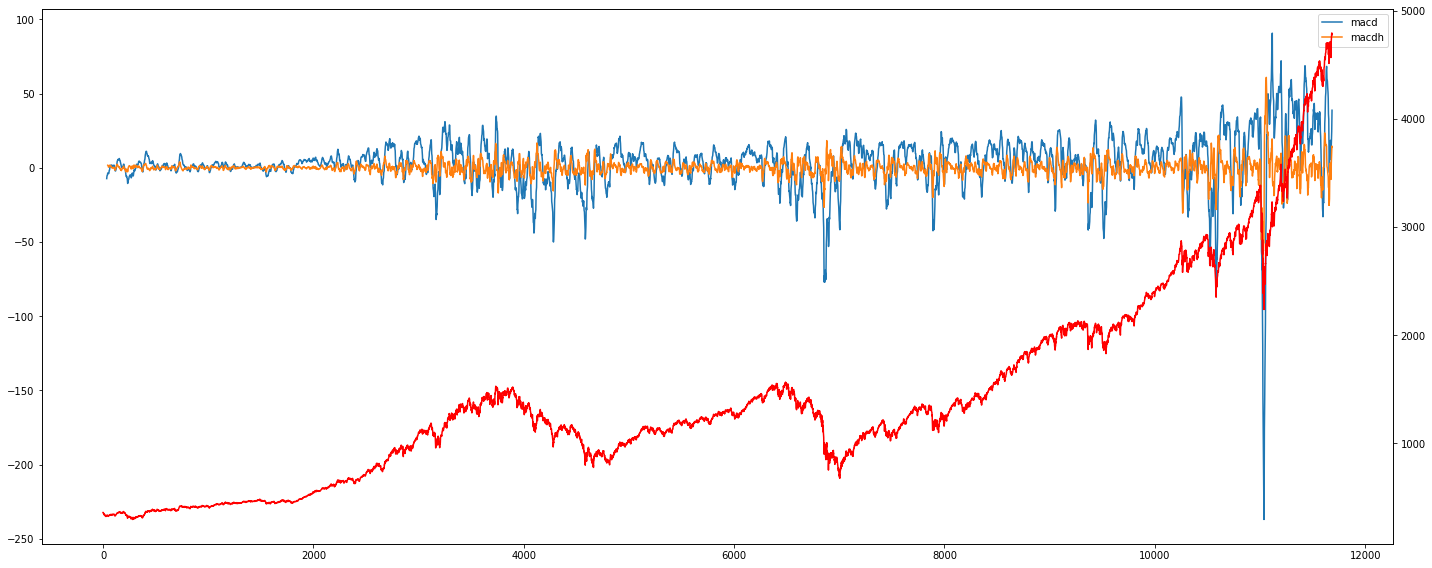

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(df.macd)
plt.plot(df.macdh)
plt.legend(['macd', 'macdh'])
ax2 = ax.twinx()
ax2.plot(df.sp_close, color="red")

plt.tight_layout()

# W%R

In [22]:
df["williamsr"] = get_williamsr(df.sp_High, df.sp_Low, df.sp_close, 10)

Save files

In [23]:
save_file(data_dict, "merged_data_dict.pkl", OUT_DATA_DIR)

In [24]:
save_file(df, file_name="merged_data.csv", file_path=OUT_DATA_DIR, index=False)